In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import time
import cv2
import os

from model import build_pretrained_model
import utils 

import warnings
warnings.filterwarnings("ignore")

## Data Pipeline 

###  Explore Data

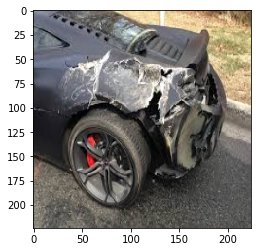

In [2]:
train_path = "data/data3a/training/03-severe/"
path_list = [os.path.join(train_path,filepath) for filepath in os.listdir(train_path)]

idx = 3
img = utils.load_image(path_list[idx])
plt.imshow(img.astype(np.int))
plt.show()

### Create Dataset 

In [3]:
def create_dataset(train_path, test_path=None, valid_size=0.1, batch_size=32):
    X_train, X_val, y_train, y_val = utils.read_data(
        data_path=train_path,
        valid_size=valid_size)

    enc = LabelEncoder()
    enc.fit(y_train)
    print(enc.classes_)
    
    with open("models/label_enc.pkl", "wb") as f:
        pickle.dump(enc, f)

    y_train = enc.transform(y_train)
    y_train = to_categorical(y_train)

    train_gen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True)

    train_gen.fit(X_train)

    y_val = enc.transform(y_val)
    y_val = to_categorical(y_val)

    valid_gen = image.ImageDataGenerator(
        preprocessing_function=preprocess_input)

    valid_gen.fit(X_val)

    print("train: {}".format(len(y_train)))
    print("valid: {}".format(len(y_val)))

    if test_path is not None:
        X_test, y_test = utils.read_data(
            data_path=test_path,
            valid_size=0)

        y_test = enc.transform(y_test)
        y_test = to_categorical(y_test)

        test_gen = image.ImageDataGenerator(
            preprocessing_function=preprocess_input)
        
        test_gen.fit(X_test)

        train_gen = train_gen.flow(X_train, y_train, batch_size)
        valid_gen = valid_gen.flow(X_val, y_val, batch_size)
        test_gen = test_gen.flow(X_test, y_test, batch_size)
        
        print("test: {}".format(len(y_test)))

        return train_gen, valid_gen, test_gen

    valid_gen = valid_gen.flow(X_val, y_val, batch_size)
    test_gen = test_gen.flow(X_test, y_test, batch_size) 

    return train_gen, valid_gen

## Modeling 

### Replace Top layers

In [41]:
def build_pretrained_model(
    base_model,
    hidden_dim=1024, 
    n_classes=6):

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(hidden_dim, activation='relu')(x)
    x = Dropout(0.8)(x)
    # and a logistic layer 
    preds = Dense(n_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=preds)
    
    return model

### Create Model 

In [42]:
hidden_dim = 128
n_classes = 3

base_model = ResNet50(
    input_shape=(224,224,3), 
    weights='imagenet', 
    include_top=False)

model =  build_pretrained_model(
    base_model=base_model,
    hidden_dim=hidden_dim,
    n_classes=n_classes)

# model.summary()

### Adjust trainable layers 

In [43]:
# train only the top layers 
for layer in base_model.layers:
    layer.trainable = False
    if "5c_" in layer.name:
        layer.trainable = True

### Training Process

In [44]:
def train(model, train_gen, valid_gen, test_gen, 
          train_steps, valid_steps, 
          optim=Adam(lr=1e-4), epochs=30):
    
    early_stopping = EarlyStopping(
        monitor='val_acc', patience=10, verbose=0, mode='max')
    
    model.compile(optimizer=optim, 
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
    
    history = model.fit_generator(
        generator=train_gen, 
        steps_per_epoch=train_steps,
        validation_data=valid_gen,
        validation_steps=valid_steps,
        epochs=epochs, 
        callbacks=[early_stopping])

    test_loss, test_acc = model.evaluate_generator(test_gen)
    print('accuracy: {}'. format(test_acc))
    print('loss: {}'.format(test_loss))
    
    # summarize history for accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train', 'valid'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train', 'valid'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

    model_path = 'models/model_{}acc.h5'.format(int(test_acc*100))
    tf.keras.models.save_model(model, model_path)

    print("Successfully Saved {}".format(model_path))

    return model

### Hyperparameters

In [39]:
learning_rate = 5e-5
batch_size = 128
epochs = 100

In [9]:
train_gen, valid_gen, test_gen = create_dataset(
    train_path="data/data3a/training/",
    test_path="data/data3a/validation/",
    valid_size=0.15,
    batch_size=batch_size)

['01-minor' '02-moderate' '03-severe']
train: 832
valid: 147
test: 171


Epoch 1/100
7/7 [==============================] - 9s 1s/step - loss: 1.8629 - acc: 0.3573 - val_loss: 1.1759 - val_acc: 0.4286
Epoch 2/100
7/7 [==============================] - 7s 929ms/step - loss: 1.4819 - acc: 0.3743 - val_loss: 1.0957 - val_acc: 0.4490
Epoch 3/100
7/7 [==============================] - 7s 1s/step - loss: 1.2890 - acc: 0.4385 - val_loss: 1.0470 - val_acc: 0.4694
Epoch 4/100
7/7 [==============================] - 7s 1s/step - loss: 1.2146 - acc: 0.4659 - val_loss: 0.9931 - val_acc: 0.4898
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 1.1536 - acc: 0.4512 - val_loss: 0.9602 - val_acc: 0.5034
Epoch 6/100
7/7 [==============================] - 7s 1s/step - loss: 1.0487 - acc: 0.5174 - val_loss: 0.9484 - val_acc: 0.4966
Epoch 7/100
7/7 [==============================] - 7s 1s/step - loss: 1.0127 - acc: 0.5095 - val_loss: 0.9321 - val_acc: 0.4966
Epoch 8/100
7/7 [==============================] - 7s 1s/step - loss: 0.9264 - acc: 0.5675 - val_loss

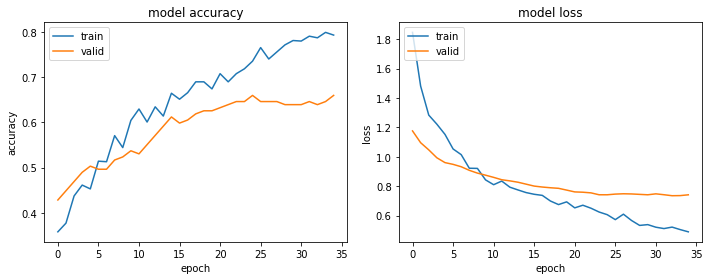

Successfully Saved models/model_62acc.h5


In [45]:
train_steps = np.ceil(train_gen.n/batch_size)
valid_steps = np.ceil(valid_gen.n/batch_size)

train(model=model,
      train_gen=train_gen,
      valid_gen=valid_gen,
      test_gen=test_gen,
      train_steps=train_steps,
      valid_steps=valid_steps,
      optim=Adam(lr=learning_rate), 
      epochs=epochs)

### Testing model performance 

In [46]:
def test(model, X_test, y_test, enc):

    y_test_pred = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred,axis=1)
    
    test_acc = metrics.accuracy_score(enc.transform(y_test), y_test_pred)
    print("Accuracy: {}".format(test_acc))
    
    y_test_pred_labels = enc.inverse_transform(y_test_pred)
    
    cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred_labels, labels=enc.classes_)
    plt.figure()
    utils.plot_confusion_matrix(cm, enc.classes_, normalize=False)
    plt.show()

    return y_test_pred_labels### Testing model performance 

In [47]:
X_test, y_test = utils.read_data("data/data3a/validation/")
X_test = np.array(list(map(preprocess_input, X_test)))

In [48]:
enc = pickle.load(open("models/label_enc.pkl", "rb"))
# model = tf.keras.models.load_model("models/model_64acc.h5")

Accuracy: 0.6257309941520468


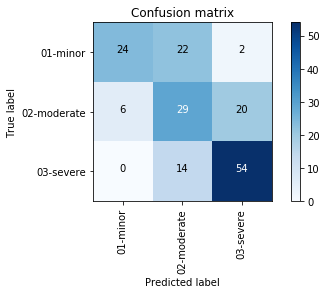

In [49]:
y_test_pred_labels = test(model, X_test, y_test, enc)

### Check the false positive cases 

Pred: 02-moderate, True: 01-minor


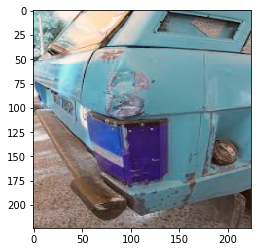

In [50]:
idx = 10

error_mask = (y_test_pred_labels != y_test)
print('Pred: {}, True: {}'. format(y_test_pred_labels[error_mask][idx], y_test[error_mask][idx]))

plt.imshow(utils.standard_scaler(X_test[error_mask][idx]))### Check the false positive cases 